In [ ]:
# Mounting google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pwd

/content


In [ ]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/MyDrive/Speech Emotion Recognition"
!cd "/content/drive/MyDrive/Speech Emotion Recognition"
!ls

 Dataset-20230927T075328Z-001		  'LSTM Speech recognition'
 dataset_attr.csv			   model.json
 demo_audio2.wav			   Others-20230927T075341Z-001
 demo_audio4.wav			   Predictions.csv
 demo_audio5.wav			   Predictions.xlsx
 demo_audio.wav				   speech_emotion_recognition.ipynb
 features_dataframe-20230927T075332Z-001   Trained_Models-20230927T075344Z-001
 img_data-20230927T075336Z-001		   utils-20230928T164634Z-001
drive  sample_data


Installation of Dependencies


Essential requirement of of our project :
1. **Python 3.7**
2. **Librosa**
3. **PyTorch**
4. **Keras**
5. **GPU**

In [ ]:
! pip install keras.utils
! pip install np_utils

  Preparing metadata (setup.py) ... done
  Created wheel for keras.utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2632 sha256=e2dccc047f6a6799c7240da190c9d972b5052a772cfcf029bd2077462993cbfa
  Stored in directory: /root/.cache/pip/wheels/5c/c0/b3/0c332de4fd71f3733ea6d61697464b7ae4b2b5ff0300e6ca7a
Successfully built keras.utils
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56439 sha256=c11ec151f80174a8eeb5f11aaab3f172bd3204bf31831752a2ef8e1acbb4887f
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


In [ ]:
# Provides a way of using operating system dependent functionality.
import os

# LibROSA provides the audio analysis
import librosa
# Need to implictly import from librosa
import librosa.display

# Import the audio playback widget
import IPython.display as ipd
from IPython.display import Image

# Enable plot in the notebook
%pylab inline
%matplotlib inline
import matplotlib.pyplot as plt

# These are generally useful to have around
import numpy as np
import pandas as pd


# To build Neural Network and Create desired Model
import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D #, AveragePooling1D
from keras.layers import Flatten, Dropout, Activation # Input,
from keras.layers import Dense #, Embedding
#from keras.utils import np_utils
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

Populating the interactive namespace from numpy and matplotlib


Data Preparation

Plotting the audio file's waveform and its spectrogram

In [ ]:
data, sampling_rate = librosa.load('/content/drive/MyDrive/Speech Emotion Recognition/Dataset-20230927T075328Z-001/Dataset/anger/anger016.wav')
# To play audio this in the jupyter notebook
ipd.Audio('/content/drive/MyDrive/Speech Emotion Recognition/Dataset-20230927T075328Z-001/Dataset/anger/anger016.wav')

In [ ]:
len(data)

87553

In [ ]:
sampling_rate

22050

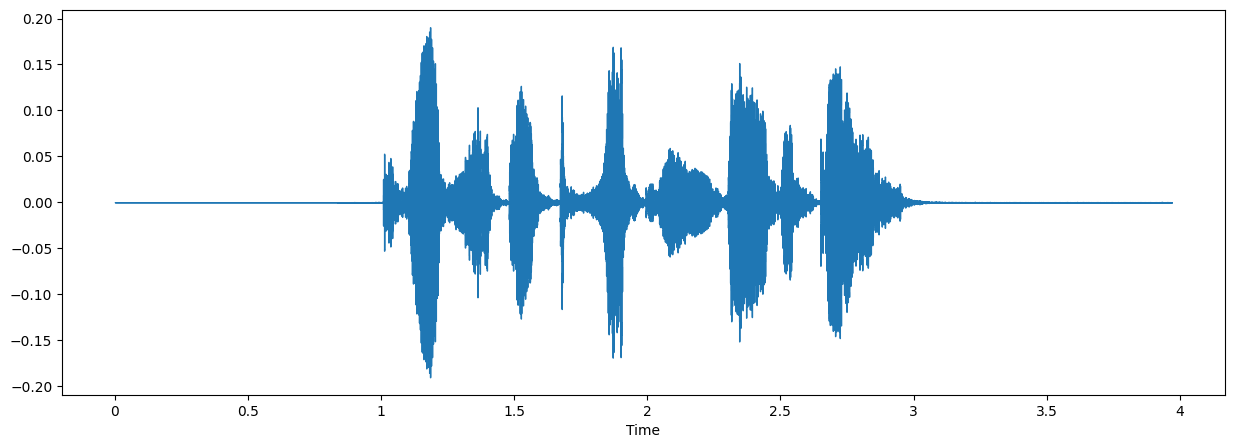

In [ ]:
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

Setup the Basic Paramter

In [ ]:
dataset_path = os.path.abspath('/content/drive/MyDrive/Speech Emotion Recognition/Dataset-20230927T075328Z-001/Dataset')
destination_path = os.path.abspath('./')
# To shuffle the dataset instances/records
randomize = True
# for spliting dataset into training and testing dataset
split = 0.8
# Number of sample per second e.g. 16KHz
sampling_rate = 20000
emotions=["anger","disgust","fear","happy","neutral", "sad", "surprise"]

In [ ]:
!ls

drive  sample_data


Dataset.py

In [ ]:
# import required libraries
import os
import sys
import csv
import librosa
import numpy as np
import pandas as pd
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
np.random.seed(42)

def create_meta_csv(dataset_path, destination_path):
    """Create a meta csv file given a dataset folder path of Audio.

    This function creates and saves a meta csv file named 'dataset_attr.csv' given a dataset folder path of audios.
    The file will contain audios and their labels. This file can be then used to make
    train, test and val splits, randomize them and load few of them (a mini-batch) in memory
    as required. The file is saved in dataset_path folder if destination_path is not provided.

    Args:
        dataset_path (str): Path to dataset folder
        destination_path (str): Destination to store meta file if None provided, it'll store file in dataset_path
    Returns:
        True (bool): Returns True if 'dataset_attr.csv' was created successfully else returns an exception
    """
    # Change dataset path accordingly
    DATASET_PATH = os.path.abspath(dataset_path)
    csv_path=os.path.join(destination_path, '/content/drive/MyDrive/Speech Emotion Recognition/Dataset-20230927T075328Z-001/Dataset/dataset_attr.csv')
    flist = []
    emotions=["anger","disgust","fear","happy","neutral", "sad", "surprise"]
    for root, dirs, files in os.walk(DATASET_PATH, topdown=False):
        for name in files:
            if (name.endswith('.wav')):
                fullName = os.path.join(root, name)
                flist.append(fullName)

    split_format = str('/') if sys.platform=='linux' else str('\\')

    filenames=[]
    for idx,file in enumerate(flist):
        filenames.append(file.split(split_format))
        # print(filenames[idx])
    types=[]
    for idx,path in enumerate(filenames):
        types.append((flist[idx],emotions.index(path[-2]))) ##second last location has emotion name

    with open(csv_path, 'w') as f:
        writer = csv.writer(f)
        writer.writerows([("path","label")])
        writer.writerows(types)
    f.close()
    # change destination_path to DATASET_PATH if destination_path is None
    if destination_path == None:
        destination_path = DATASET_PATH
        # write out as dataset_attr.csv in destination_path directory
        # if no error
    return True

def create_and_load_meta_csv_df(dataset_path, destination_path, randomize=True, split=None):
    """Create a meta csv file given a dataset folder path of audios and loads it as a pandas dataframe.
    This function creates and saves a meta csv file named 'dataset_attr.csv' given a dataset folder path of audios.
    The function will return pandas dataframes for the csv and also train and test splits if you specify a
    fraction in split parameter.

    Args:
        dataset_path (str): Path to dataset folder
        destination_path (str): Destination to store meta csv file
        randomize (bool, optional): Randomize the csv records. Defaults to True
        split (double, optional): Percentage of train records. Defaults to None
    Returns:
        dframe (pandas.Dataframe): Returns a single Dataframe for csv if split is none, else returns more two Dataframes for train and test splits.
        train_set (pandas.Dataframe): Returns a Dataframe of length (split) * len(dframe)
        test_set (pandas.Dataframe): Returns a Dataframe of length (1 - split) * len(dframe)
    """
    if create_meta_csv(dataset_path, destination_path=destination_path):
        dframe = pd.read_csv(os.path.join(destination_path, '/content/drive/MyDrive/Speech Emotion Recognition/Dataset-20230927T075328Z-001/Dataset/dataset_attr.csv'))

    # shuffle if randomize is True or if split specified and randomize is not specified
    # so default behavior is split
    if randomize == True or (split != None and randomize == None):
        # shuffle the dataframe here
        dframe=dframe.sample(frac=1).reset_index(drop=True)
        pass

    if split != None:
        train_set, test_set = train_test_split(dframe, split)
        return dframe, train_set, test_set

    return dframe

In [ ]:
def train_test_split(dframe, split_ratio):
    """Splits the dataframe into train and test subset dataframes.
    Args:
        split_ration (float): Divides dframe into two splits.
    Returns:
        train_data (pandas.Dataframe): Returns a Dataframe of length (split_ratio) * len(dframe)
        test_data (pandas.Dataframe): Returns a Dataframe of length (1 - split_ratio) * len(dframe)
    """
    # divide into train and test dataframes
    train_data= dframe.iloc[:int((split_ratio) * len(dframe)), :]
    test_data= dframe.iloc[int((split_ratio) * len(dframe)):,:]
    test_data=test_data.reset_index(drop=True) #reset index for test data
    return train_data, test_data

In [ ]:
if __name__ == "__main__":
    # test config
    dataset_path =  os.path.dirname(os.getcwd())+'/content/drive/MyDrive/Speech Emotion Recognition/Dataset-20230927T075328Z-001/Dataset'
    print("dataset_path : ", dataset_path)
    destination_path = os.getcwd()
    classes = 7
    total_rows = 2556
    randomize = True
    clear = True

    # test_create_meta_csv()
    df, trn_df, tst_df = create_and_load_meta_csv_df(dataset_path, destination_path=destination_path, randomize=randomize, split=0.99)
    print(df.describe())
    print(trn_df.describe())
    print(tst_df.describe())

dataset_path :  //content/drive/MyDrive/Speech Emotion Recognition/Dataset-20230927T075328Z-001/Dataset
             label
count  2650.000000
mean      2.872075
std       1.921411
min       0.000000
25%       1.000000
50%       3.000000
75%       5.000000
max       6.000000
             label
count  2623.000000
mean      2.873046
std       1.923273
min       0.000000
25%       1.000000
50%       3.000000
75%       5.000000
max       6.000000
           label
count  27.000000
mean    2.777778
std     1.761410
min     0.000000
25%     2.000000
50%     3.000000
75%     4.000000
max     6.000000


In [ ]:
!pip install utils

Converting Dataset in CSV format

In [ ]:
# loading dataframes using dataset module
#from utils import dataset

# To know more about "create_and_load_meta_csv_df" function and it's working, go to "./utils/dataset.py" script.
df, train_df, test_df = create_and_load_meta_csv_df(dataset_path, destination_path, randomize, split)

In [ ]:
print('Dataset samples  : ', len(df),"\nTraining Samples : ", len(train_df),"\ntesting Samples  : ", len(test_df))

Dataset samples  :  2650 
Training Samples :  2120 
testing Samples  :  530


Data Visualization

In [ ]:
df.head()

,path,label
0,//content/drive/MyDrive/Speech Emotion Recogni...,2
1,//content/drive/MyDrive/Speech Emotion Recogni...,1
2,//content/drive/MyDrive/Speech Emotion Recogni...,0
3,//content/drive/MyDrive/Speech Emotion Recogni...,0
4,//content/drive/MyDrive/Speech Emotion Recogni...,4


In [ ]:
print("Actual Audio : ", df['path'][0])
print("Labels       : ", df['label'][0])

Actual Audio :  //content/drive/MyDrive/Speech Emotion Recognition/Dataset-20230927T075328Z-001/Dataset/fear/fear040.wav
Labels       :  2


#Labels Assigned for emotions :
0 : anger
1 : disgust
2 : fear
3 : happy
4 : neutral
5 : sad
6 : surprise

In [ ]:
unique_labels = train_df.label.unique()
unique_labels.sort()
print("unique labels in Emtion dataset : ")
print(*unique_labels, sep=', ')
unique_labels_counts = train_df.label.value_counts(sort=False)
print("\n\nCount of unique labels in Emtion dataset : ")
print(*unique_labels_counts,sep=', ')

unique labels in Emtion dataset : 
0, 1, 2, 3, 4, 5, 6


Count of unique labels in Emtion dataset : 
348, 216, 371, 263, 348, 190, 384


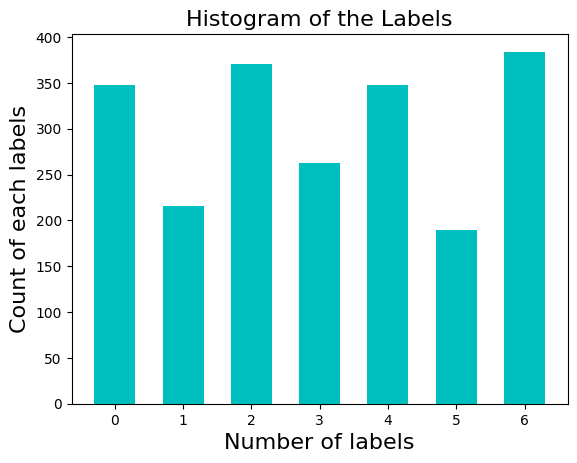

In [ ]:
# Histogram of the classes
plt.bar(unique_labels, unique_labels_counts,align = 'center', width=0.6, color = 'c')
plt.xlabel('Number of labels', fontsize=16)
plt.xticks(unique_labels)
plt.ylabel('Count of each labels', fontsize=16)
plt.title('Histogram of the Labels', fontsize=16)
plt.show()

Data Pre-Processing

Getting the features of audio files using librosa
Calculating MFCC, Pitch, magnitude, Chroma features.

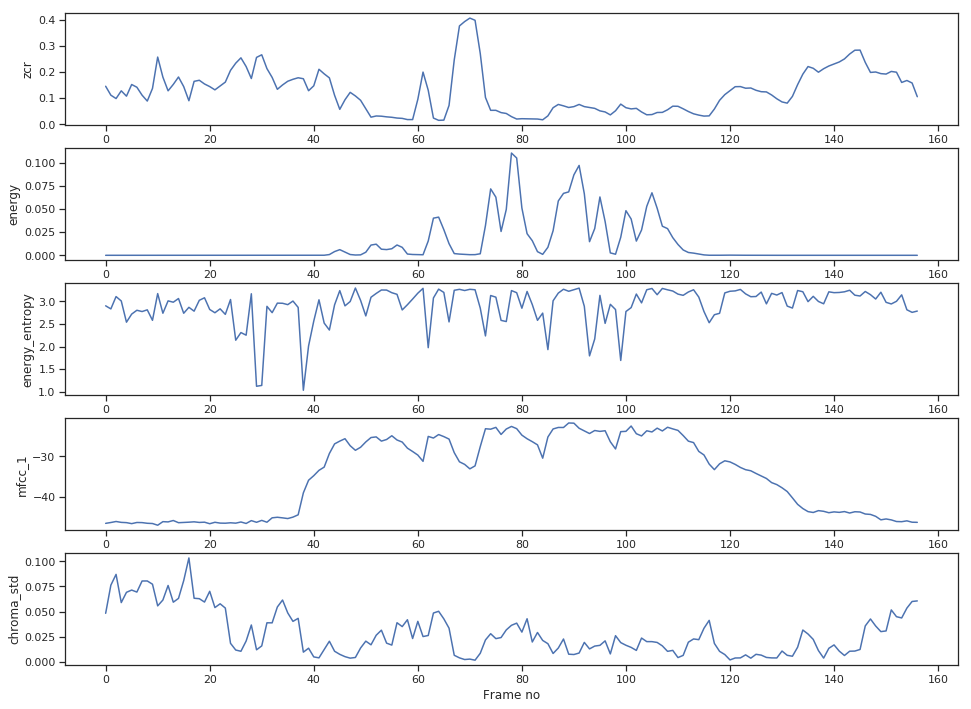

In [ ]:
from IPython.display import Image

# Specify the path to the image file
image_path = '/content/drive/MyDrive/Speech Emotion Recognition/utils-20230928T164634Z-001/utils/images/feature_plots.png'

# Create an instance of the Image class
image = Image(filename=image_path)

# Display the image
display(image)

In [ ]:
import sys
print(sys.path)


['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython']


In [ ]:
# feature_extracting
import librosa
import pandas as pd
import numpy as np

def get_audio_features(audio_path,sampling_rate):
    X, sample_rate = librosa.load(audio_path ,res_type='kaiser_fast',duration=2.5,sr=sampling_rate*2,offset=0.5)
    sample_rate = np.array(sample_rate)

    y_harmonic, y_percussive = librosa.effects.hpss(X)
    pitches, magnitudes = librosa.core.pitch.piptrack(y=X, sr=sample_rate)

    mfccs = np.mean(librosa.feature.mfcc(y=X,sr=sample_rate,n_mfcc=13),axis=1)

    pitches = np.trim_zeros(np.mean(pitches,axis=1))[:20]

    magnitudes = np.trim_zeros(np.mean(magnitudes,axis=1))[:20]

    C = np.mean(librosa.feature.chroma_cqt(y=y_harmonic, sr=sampling_rate),axis=1)

    return [mfccs, pitches, magnitudes, C]



def get_features_dataframe(dataframe, sampling_rate):
    labels = pd.DataFrame(dataframe['label'])

    features  = pd.DataFrame(columns=['mfcc','pitches','magnitudes','C'])
    for index, audio_path in enumerate(dataframe['path']):
        features.loc[index] = get_audio_features(audio_path, sampling_rate)

    mfcc = features.mfcc.apply(pd.Series)
    pit = features.pitches.apply(pd.Series)
    mag = features.magnitudes.apply(pd.Series)
    C = features.C.apply(pd.Series)

    combined_features = pd.concat([mfcc,pit,mag,C],axis=1,ignore_index=True)

    return combined_features, labels

In [ ]:
!pip install resampy
!pip install --upgrade librosa

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 15.3 MB/s eta 0:00:00


In [ ]:
#from utils.feature_extraction import get_features_dataframe
#from utils.feature_extraction import get_audio_features

#trainfeatures, trainlabel = get_features_dataframe(train_df, sampling_rate)
#testfeatures, testlabel = get_features_dataframe(test_df, sampling_rate)

# I have ran above 2 lines and get the featured dataframe.
# and store it into pickle file to use it for later purpose.
# it take too much time to generate features(around 30-40 minutes).

trainfeatures = pd.read_pickle('/content/drive/MyDrive/Speech Emotion Recognition/features_dataframe-20230927T075332Z-001/features_dataframe/trainfeatures')
trainlabel = pd.read_pickle('/content/drive/MyDrive/Speech Emotion Recognition/features_dataframe-20230927T075332Z-001/features_dataframe/trainlabel')
testfeatures = pd.read_pickle('/content/drive/MyDrive/Speech Emotion Recognition/features_dataframe-20230927T075332Z-001/features_dataframe/testfeatures')
testlabel = pd.read_pickle('/content/drive/MyDrive/Speech Emotion Recognition/features_dataframe-20230927T075332Z-001/features_dataframe/testlabel')

In [ ]:
trainfeatures.shape

(2044, 65)

In [ ]:
trainfeatures = trainfeatures.fillna(0)
testfeatures = testfeatures.fillna(0)

In [ ]:
# By using .ravel() : Converting 2D to 1D e.g. (512,1) -> (512,). To prevent DataConversionWarning

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel).ravel()
X_test = np.array(testfeatures)
y_test = np.array(testlabel).ravel()

In [ ]:
y_train[:5]

array([3, 2, 2, 0, 3])

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Create an instance of the LabelEncoder
lb = LabelEncoder()

# Encode your labels
y_train_encoded = lb.fit_transform(y_train)
y_test_encoded = lb.transform(y_test)

# Convert the encoded labels to one-hot encoding
num_classes = len(lb.classes_)
y_train_one_hot = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test_encoded, num_classes=num_classes)


In [ ]:
y_train_one_hot[:5]

array([[0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

Changing dimension for CNN model

In [ ]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [ ]:
x_traincnn.shape

(2044, 65, 1)

NAIVE BAYES

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming x_traincnn has shape (num_samples, num_time_steps, num_features)
# Reshape it into (num_samples, num_time_steps * num_features)
X_train = x_traincnn.reshape(x_traincnn.shape[0], -1)

# Initialize and train the Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

# Assuming x_testcnn is your testing data, reshape it similarly
X_test = x_testcnn.reshape(x_testcnn.shape[0], -1)

# Make predictions on the testing set
y_pred = nb_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)


Accuracy: 0.26953125
Confusion Matrix:
[[10 18  0  3  2 47  1]
 [ 7 27  1  0  6 19  0]
 [ 2 23  4  3  4 45  2]
 [ 2 21  0  7  5 48  2]
 [ 4  9  1  0 14 24  1]
 [ 3 18  1  1  4 70  0]
 [ 1 25  1  5  4 11  6]]
Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.12      0.18        81
           1       0.19      0.45      0.27        60
           2       0.50      0.05      0.09        83
           3       0.37      0.08      0.13        85
           4       0.36      0.26      0.30        53
           5       0.27      0.72      0.39        97
           6       0.50      0.11      0.18        53

    accuracy                           0.27       512
   macro avg       0.36      0.26      0.22       512
weighted avg       0.36      0.27      0.22       512



SVM

Accuracy: 0.51171875
Confusion Matrix:
[[56  2 11  8  0  2  2]
 [15 21  6  1  4  7  6]
 [ 9  5 46  8  2  8  5]
 [11  2 14 43  3  8  4]
 [ 3  2  8  3 29  8  0]
 [ 7  8 18  2 12 49  1]
 [ 6  5 10  8  3  3 18]]
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.69      0.60        81
           1       0.47      0.35      0.40        60
           2       0.41      0.55      0.47        83
           3       0.59      0.51      0.54        85
           4       0.55      0.55      0.55        53
           5       0.58      0.51      0.54        97
           6       0.50      0.34      0.40        53

    accuracy                           0.51       512
   macro avg       0.52      0.50      0.50       512
weighted avg       0.52      0.51      0.51       512



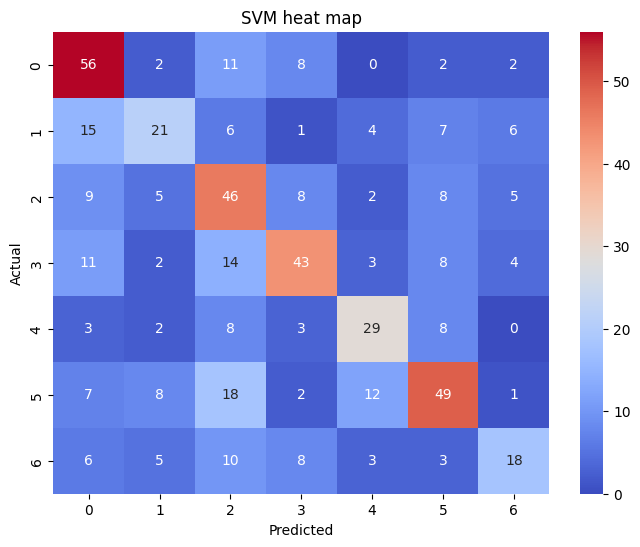

In [ ]:
import seaborn as sns
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming you have already split your data into x_train, y_train, x_test, y_test

# Create an SVM classifier (you can choose different kernel functions)
clf = svm.SVC(kernel='linear')

# Train the SVM classifier on the training data
clf.fit(X_train, y_train)

X_test = x_testcnn.reshape(x_testcnn.shape[0], -1)
y_test = y_test.reshape(-1)
# Make predictions on the testing data
y_pred = clf.predict(X_test)

# Evaluate the SVM model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)

#Plotting the confusion mattrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVM heat map')
plt.show()

MLPclassifier

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming you have already split your data into x_train, y_train, x_test, y_test

# Create an MLP classifier with desired parameters (e.g., hidden layer sizes and activation function)
clf = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', max_iter=1000)

X_train = x_traincnn.reshape(x_traincnn.shape[0], -1)

# Train the MLP classifier on the training data
clf.fit(X_train, y_train)

X_test = x_testcnn.reshape(x_testcnn.shape[0], -1)

# Make predictions on the testing data
y_pred = clf.predict(X_test)

# Evaluate the MLP model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)


Accuracy: 0.517578125
Confusion Matrix:
[[52 10  3  6  0  5  5]
 [ 6 29  5  1  5  6  8]
 [12 10 27  7  0 16 11]
 [10  5  7 39  1 10 13]
 [ 0 10  3  1 30  6  3]
 [ 5 11  4  4  8 56  9]
 [ 0  9  3  3  0  6 32]]
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.64      0.63        81
           1       0.35      0.48      0.40        60
           2       0.52      0.33      0.40        83
           3       0.64      0.46      0.53        85
           4       0.68      0.57      0.62        53
           5       0.53      0.58      0.55        97
           6       0.40      0.60      0.48        53

    accuracy                           0.52       512
   macro avg       0.53      0.52      0.52       512
weighted avg       0.54      0.52      0.52       512



Model Creation

CNN MODEL

In [ ]:
print(y_train.shape)


(2044,)


In [ ]:
from keras.optimizers import Adam
import tensorflow as tf  # Import TensorFlow for the legacy optimizer

model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(x_traincnn.shape[1],x_traincnn.shape[2])))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
num_classes = 7  # Replace with the actual number of classes
model.add(Dense(num_classes, activation='softmax'))

# Compile the model with the Adam optimizer
opt = Adam(learning_rate=0.00001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
#model.add(Activation('softmax'))
#opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 65, 256)           1536      
                                                                 
 activation (Activation)     (None, 65, 256)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 65, 128)           163968    
                                                                 
 activation_1 (Activation)   (None, 65, 128)           0         
                                                                 
 dropout (Dropout)           (None, 65, 128)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 8, 128)            0         
 D)                                                              
                                                        

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

Training and Evaluation

Removed the whole training part for avoiding unnecessary long epochs list

In [ ]:
cnnhistory=model.fit(x_traincnn, y_train_one_hot, batch_size=16, epochs=370, validation_data=(x_testcnn, y_test_one_hot))

Epoch 1/370
128/128 [==============================] - 13s 10ms/step - loss: 2.2417 - accuracy: 0.1531 - val_loss: 1.8732 - val_accuracy: 0.2422
Epoch 2/370
128/128 [==============================] - 1s 5ms/step - loss: 1.8770 - accuracy: 0.2392 - val_loss: 1.7488 - val_accuracy: 0.2969
Epoch 3/370
128/128 [==============================] - 1s 6ms/step - loss: 1.7810 - accuracy: 0.2808 - val_loss: 1.6917 - val_accuracy: 0.3184
Epoch 4/370
128/128 [==============================] - 1s 8ms/step - loss: 1.7178 - accuracy: 0.3151 - val_loss: 1.6649 - val_accuracy: 0.3184
Epoch 5/370
128/128 [==============================] - 1s 8ms/step - loss: 1.6884 - accuracy: 0.3425 - val_loss: 1.6704 - val_accuracy: 0.3477
Epoch 6/370
128/128 [==============================] - 1s 7ms/step - loss: 1.6662 - accuracy: 0.3498 - val_loss: 1.6139 - val_accuracy: 0.3691
Epoch 7/370
128/128 [==============================] - 1s 7ms/step - loss: 1.6206 - accuracy: 0.3625 - val_loss: 1.5979 - val_accuracy: 0.38

Loss Vs Iterations

16/16 [==============================] - 0s 2ms/step
Confusion Matrix:
 [[51  3 10 14  0  0  3]
 [ 5 32  7  2  6  7  1]
 [ 2  4 54  6  3 10  4]
 [ 2  3  9 59  1  6  5]
 [ 0  4  0  6 34  6  3]
 [ 6  7 19  8  7 50  0]
 [ 3  5 11  5  1  2 26]]


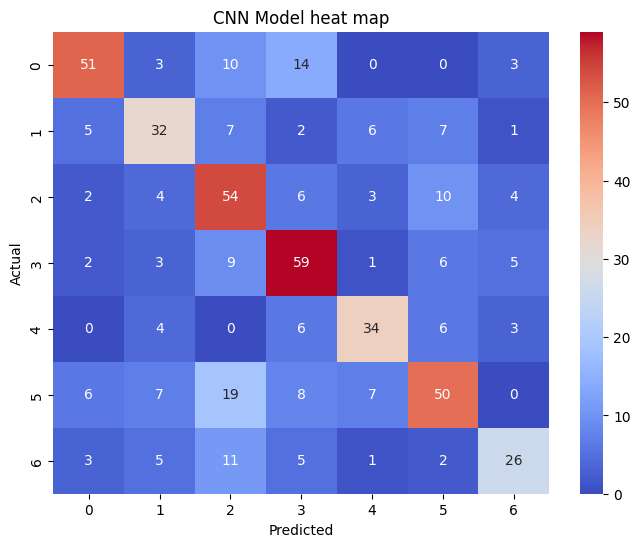

              precision    recall  f1-score   support

           0       0.74      0.63      0.68        81
           1       0.55      0.53      0.54        60
           2       0.49      0.65      0.56        83
           3       0.59      0.69      0.64        85
           4       0.65      0.64      0.65        53
           5       0.62      0.52      0.56        97
           6       0.62      0.49      0.55        53

    accuracy                           0.60       512
   macro avg       0.61      0.59      0.60       512
weighted avg       0.61      0.60      0.60       512



In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Assuming model is your trained hybrid model
predictions = model.predict([x_testcnn])  # Adjust accordingly

# Convert one-hot encoded labels back to labels
y_pred_labels = np.argmax(predictions, axis=1)
y_true_labels = np.argmax(y_test_one_hot, axis=1)

# Compute confusion matrix and classification report
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
classification_rep = classification_report(y_true_labels, y_pred_labels)

# Now, you can print or visualize the confusion matrix
print("Confusion Matrix:\n", conf_matrix)

#Plotting the confusion mattrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('CNN Model heat map')
plt.show()

print(classification_report(y_true_labels, y_pred_labels))


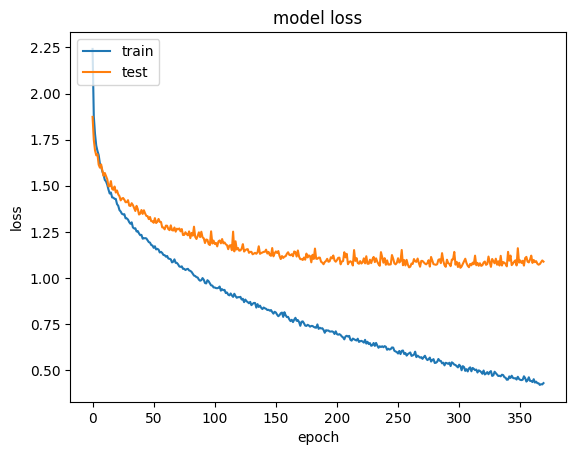

In [ ]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

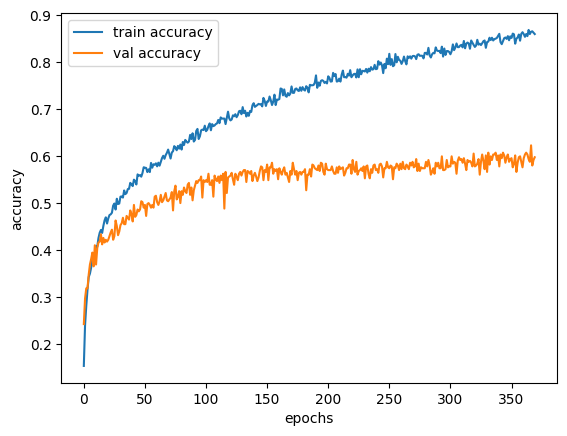

In [ ]:
epochs = list(range(370))
acc = cnnhistory.history['accuracy']
val_acc = cnnhistory.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
model_name = 'omar.h5'
save_dir = os.path.join(os.getcwd(), '/content/drive/MyDrive/Speech Emotion Recognition/Trained_Models-20230927T075344Z-001/Trained_Models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved trained model at /content/drive/MyDrive/Speech Emotion Recognition/Trained_Models-20230927T075344Z-001/Trained_Models/omar.h5 


In [ ]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

Loading the model

In [ ]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/Speech Emotion Recognition/Trained_Models-20230927T075344Z-001/Trained_Models/omar.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test_one_hot, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 59.77%


DSCNN

In [ ]:
print(x_traincnn.shape)


(2044, 65, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define the DSCNN architecture
def create_dscnn_model(input_shape):
    model = Sequential()

    # Convolutional layers with MaxPooling and strides

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', strides=2))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu', strides=2))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the output for Dense layers
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))  # Output layer

    return model

# Set the input shape and number of classes
input_shape=(x_traincnn.shape[0],x_traincnn.shape[1], 1)
num_classes = 7 # Set the number of classes

# Create the DSCNN model
dscnn_model = create_dscnn_model(input_shape)

# Compile the model
dscnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
dscnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 2042, 63, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 1021, 31, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 510, 15, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 255, 7, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 127, 3, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 63, 1, 128)       

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
dscnnhistory=model.fit(x_traincnn, y_train_one_hot, batch_size=16, epochs=370, validation_data=(x_testcnn, y_test_one_hot))

Epoch 1/370
128/128 [==============================] - 3s 9ms/step - loss: 2.4118 - accuracy: 0.3601 - val_loss: 1.4813 - val_accuracy: 0.4180
Epoch 2/370
128/128 [==============================] - 1s 8ms/step - loss: 1.5010 - accuracy: 0.4198 - val_loss: 1.3981 - val_accuracy: 0.4531
Epoch 3/370
128/128 [==============================] - 1s 6ms/step - loss: 1.3693 - accuracy: 0.4716 - val_loss: 1.3528 - val_accuracy: 0.4531
Epoch 4/370
128/128 [==============================] - 1s 6ms/step - loss: 1.3009 - accuracy: 0.4878 - val_loss: 1.3429 - val_accuracy: 0.4492
Epoch 5/370
128/128 [==============================] - 1s 6ms/step - loss: 1.2416 - accuracy: 0.5215 - val_loss: 1.2324 - val_accuracy: 0.5098
Epoch 6/370
128/128 [==============================] - 1s 6ms/step - loss: 1.2084 - accuracy: 0.5342 - val_loss: 1.2710 - val_accuracy: 0.5059
Epoch 7/370
128/128 [==============================] - 1s 6ms/step - loss: 1.1461 - accuracy: 0.5548 - val_loss: 1.1834 - val_accuracy: 0.5234

16/16 [==============================] - 1s 16ms/step
Confusion Matrix:
 [[ 0 29 52  0  0  0  0]
 [ 0 42 18  0  0  0  0]
 [ 0 29 48  5  0  1  0]
 [ 0 32 46  7  0  0  0]
 [ 0 13 32  8  0  0  0]
 [ 0 44 40 13  0  0  0]
 [ 0 28 19  6  0  0  0]]


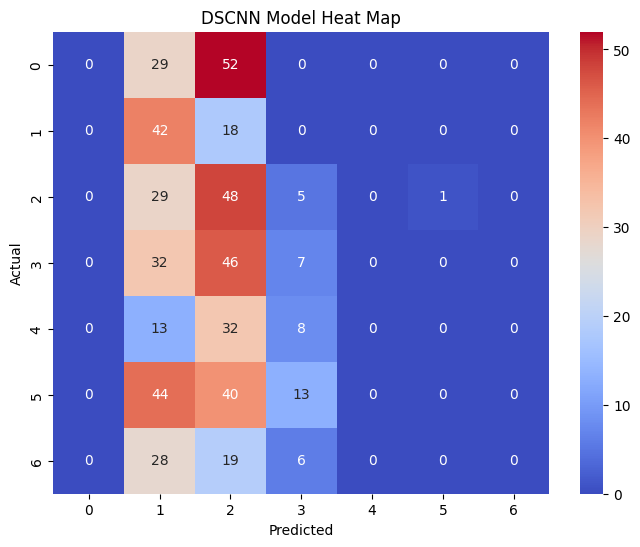

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        81
           1       0.19      0.70      0.30        60
           2       0.19      0.58      0.28        83
           3       0.18      0.08      0.11        85
           4       0.00      0.00      0.00        53
           5       0.00      0.00      0.00        97
           6       0.00      0.00      0.00        53

    accuracy                           0.19       512
   macro avg       0.08      0.19      0.10       512
weighted avg       0.08      0.19      0.10       512



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Reshape it to (32, 2044, 65, 1) to match the model's input shape
x_testcnn_reshaped = np.expand_dims(x_testcnn, axis=1)  # Add a dimension at the second axis
x_testcnn_reshaped = np.repeat(x_testcnn_reshaped, 2044, axis=1)  # Repeat along the second axis

# Now, you can use x_testcnn_reshaped for predictions
y_pred = dscnn_model.predict(x_testcnn_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot encoded to class labels
y_true_classes = np.argmax(y_test_one_hot, axis=1)

# Create the confusion matrix
conf_matrx = confusion_matrix(y_true_classes, y_pred_classes)

# Now, you can print or visualize the confusion matrix
print("Confusion Matrix:\n", conf_matrx)

#Plotting the confusion mattrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrx, annot=True, cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('DSCNN Model Heat Map')
plt.show()

print(classification_report(y_true_classes, y_pred_classes))

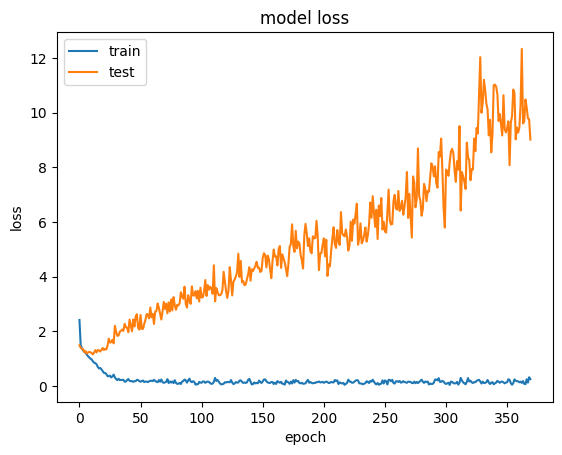

In [ ]:
plt.plot(dscnnhistory.history['loss'])
plt.plot(dscnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

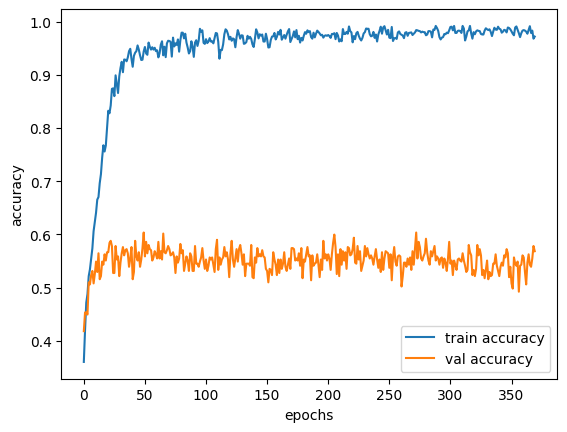

In [ ]:
epochs = list(range(370))
acc = dscnnhistory.history['accuracy']
val_acc = dscnnhistory.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
model_name = 'omar.h8'
save_dir = os.path.join(os.getcwd(), '/content/drive/MyDrive/Speech Emotion Recognition/Trained_Models-20230927T075344Z-001/Trained_Models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/MyDrive/Speech Emotion Recognition/Trained_Models-20230927T075344Z-001/Trained_Models/omar.h8 


In [ ]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/Speech Emotion Recognition/Trained_Models-20230927T075344Z-001/Trained_Models/omar.h8")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test_one_hot, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 56.84%


Create the LSTM Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout


model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(x_traincnn.shape[1],x_traincnn.shape[2])),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 7)                

In [ ]:
# Train the model
history = model.fit(x_traincnn, y_train_one_hot, batch_size=16, epochs=370, validation_data=(x_testcnn, y_test_one_hot))

Epoch 1/370
128/128 [==============================] - 6s 16ms/step - loss: 1.9259 - accuracy: 0.1737 - val_loss: 1.9237 - val_accuracy: 0.1582
Epoch 2/370
128/128 [==============================] - 1s 8ms/step - loss: 1.9249 - accuracy: 0.1928 - val_loss: 1.9254 - val_accuracy: 0.1582
Epoch 3/370
128/128 [==============================] - 1s 8ms/step - loss: 1.9118 - accuracy: 0.1996 - val_loss: 1.9257 - val_accuracy: 0.1660
Epoch 4/370
128/128 [==============================] - 1s 8ms/step - loss: 1.8967 - accuracy: 0.2030 - val_loss: 1.8858 - val_accuracy: 0.2227
Epoch 5/370
128/128 [==============================] - 1s 8ms/step - loss: 1.8691 - accuracy: 0.2055 - val_loss: 1.8372 - val_accuracy: 0.2363
Epoch 6/370
128/128 [==============================] - 1s 8ms/step - loss: 1.8185 - accuracy: 0.2192 - val_loss: 1.8071 - val_accuracy: 0.2871
Epoch 7/370
128/128 [==============================] - 1s 7ms/step - loss: 1.7790 - accuracy: 0.2544 - val_loss: 1.8511 - val_accuracy: 0.236

16/16 [==============================] - 0s 4ms/step
Confusion Matrix:
 [[57  4  9  7  2  0  2]
 [ 6 31  4  6  6  5  2]
 [ 4  5 49  8  1 14  2]
 [14  5  3 53  1  2  7]
 [ 1  2  4  0 44  2  0]
 [ 3  7 11  6 11 59  0]
 [ 8  6  3  7  0  0 29]]


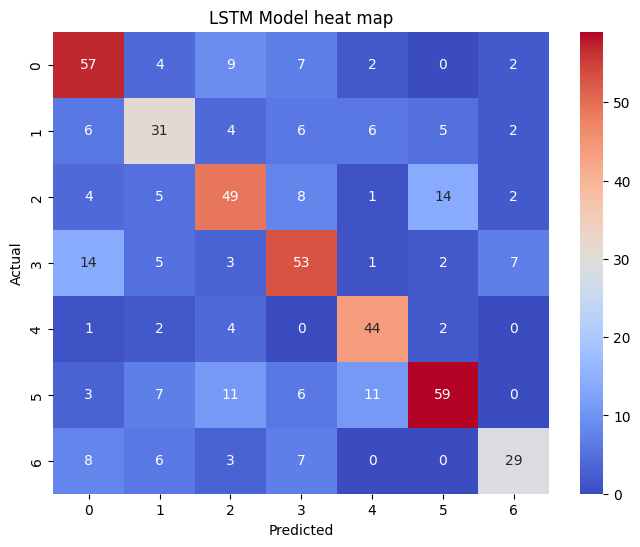

              precision    recall  f1-score   support

           0       0.61      0.70      0.66        81
           1       0.52      0.52      0.52        60
           2       0.59      0.59      0.59        83
           3       0.61      0.62      0.62        85
           4       0.68      0.83      0.75        53
           5       0.72      0.61      0.66        97
           6       0.69      0.55      0.61        53

    accuracy                           0.63       512
   macro avg       0.63      0.63      0.63       512
weighted avg       0.63      0.63      0.63       512



In [ ]:
y_pred = model.predict(x_testcnn)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot encoded to class labels
y_true_classes = np.argmax(y_test_one_hot, axis=1)

# 3. Create the confusion matrix
confusion_mtx = confusion_matrix(y_true_classes, y_pred_classes)

# Now, you can print or visualize the confusion matrix
print("Confusion Matrix:\n", confusion_mtx)

#Plotting the confusion mattrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LSTM Model heat map')
plt.show()

print(classification_report(y_true_classes, y_pred_classes))

Plot the results

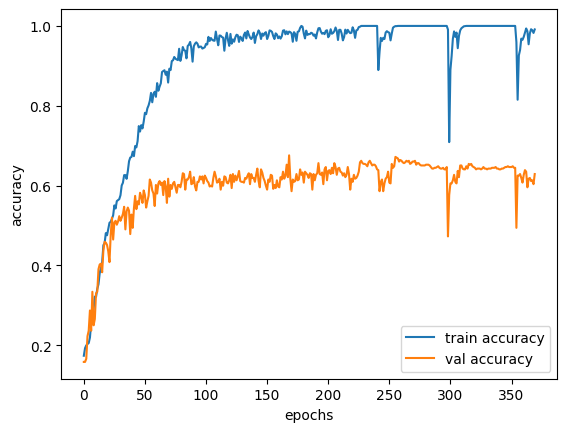

In [ ]:
epochs = list(range(370))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

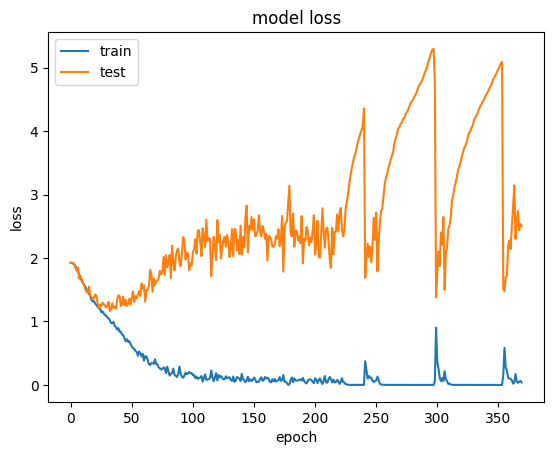

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model_name = 'omar.h6'
save_dir = os.path.join(os.getcwd(), '/content/drive/MyDrive/Speech Emotion Recognition/Trained_Models-20230927T075344Z-001/Trained_Models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/MyDrive/Speech Emotion Recognition/Trained_Models-20230927T075344Z-001/Trained_Models/omar.h6 


In [ ]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/Speech Emotion Recognition/Trained_Models-20230927T075344Z-001/Trained_Models/omar.h6")
print("Loaded model from disk")

# evaluate loaded model on test data
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = model.evaluate(x_testcnn, y_test_one_hot, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 62.89%


CNN-LSTM

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Concatenate
from keras.layers import Dropout

# Define the input layers for CNN and LSTM
cnn_input = Input(shape=(x_traincnn.shape[1],x_traincnn.shape[2]))
lstm_input = Input(shape=(x_traincnn.shape[1],x_traincnn.shape[2]))


# Build CNN model
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(x_traincnn.shape[1],x_traincnn.shape[2])))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
num_classes = 7
model.add(Dense(num_classes, activation='softmax'))

model_cnn = Conv1D(filters=32, kernel_size=3, activation='relu')(cnn_input)
model_cnn = MaxPooling1D(pool_size=2)(model_cnn)
model_cnn = Flatten()(model_cnn)

#compile and train CNN model
#opt = Adam(learning_rate=0.00001)
#model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
#history=model.fit(x_traincnn, y_train_one_hot, batch_size=16, epochs=100, validation_data=(x_testcnn, y_test_one_hot))

# Build LSTM model
model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(x_traincnn.shape[1],x_traincnn.shape[2])),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])
model_lstm = LSTM(units=64)(lstm_input)

# Combine models
combined_input = Concatenate()([model_cnn, model_lstm])
final_output = Dense(num_classes, activation='softmax')(combined_input)

hybrid_model = Model(inputs=[cnn_input, lstm_input], outputs=final_output)

# Compile the model
hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

hybrid_model.summary()

# Train the model
hybrid_model_history=hybrid_model.fit([x_traincnn, x_traincnn], y_train_one_hot, epochs=370, batch_size=16, validation_split=0.2)

# Evaluate the model on a test set (assuming you have x_test_cnn, x_test_lstm, y_test)
loss, accuracy = hybrid_model.evaluate([x_testcnn, x_testcnn], y_test_one_hot)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

# Make predictions on new data (assuming you have x_new_cnn, x_new_lstm)
predictions = hybrid_model.predict([x_testcnn, x_testcnn])


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 65, 1)]              0         []                            
                                                                                                  
 conv1d_8 (Conv1D)           (None, 63, 32)               128       ['input_1[0][0]']             
                                                                                                  
 max_pooling1d_2 (MaxPoolin  (None, 31, 32)               0         ['conv1d_8[0][0]']            
 g1D)                                                                                             
                                                                                                  
 input_2 (InputLayer)        [(None, 65, 1)]              0         []                        

16/16 [==============================] - 0s 5ms/step
Confusion Matrix:
 [[48  5 16  8  0  0  4]
 [ 8 23  5  5  6  5  8]
 [15  3 41  7  3  6  8]
 [ 7  3  7 58  0  6  4]
 [ 0  0  2  4 40  7  0]
 [ 6  6 14  4 15 48  4]
 [ 4  5  5  8  3  0 28]]


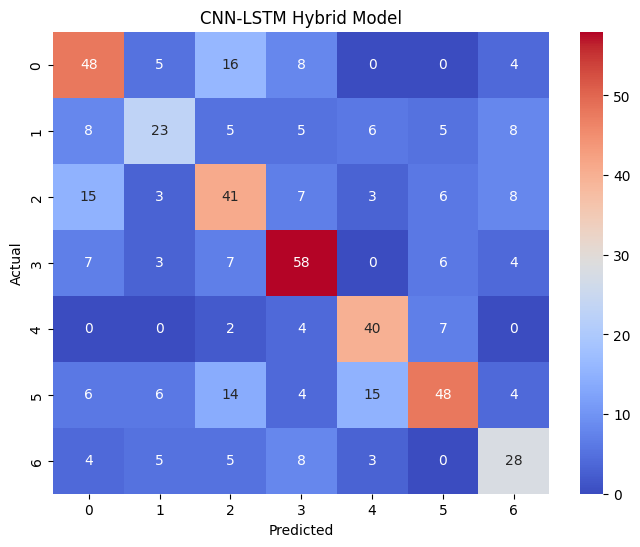

              precision    recall  f1-score   support

           0       0.55      0.59      0.57        81
           1       0.51      0.38      0.44        60
           2       0.46      0.49      0.47        83
           3       0.62      0.68      0.65        85
           4       0.60      0.75      0.67        53
           5       0.67      0.49      0.57        97
           6       0.50      0.53      0.51        53

    accuracy                           0.56       512
   macro avg       0.56      0.56      0.55       512
weighted avg       0.56      0.56      0.56       512



In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

y_pred = hybrid_model.predict([x_testcnn, x_testcnn])
y_pred_class = np.argmax(y_pred, axis=1)  # Convert one-hot encoded to class labels
y_true_class = np.argmax(y_test_one_hot, axis=1)

# Create the confusion matrix
conf_mattrix = confusion_matrix(y_true_class, y_pred_class)

# Now, you can print or visualize the confusion matrix
print("Confusion Matrix:\n", conf_mattrix)


#Plotting the confusion mattrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mattrix, annot=True, cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('CNN-LSTM Hybrid Model')
plt.show()

print(classification_report(y_true_class, y_pred_class))

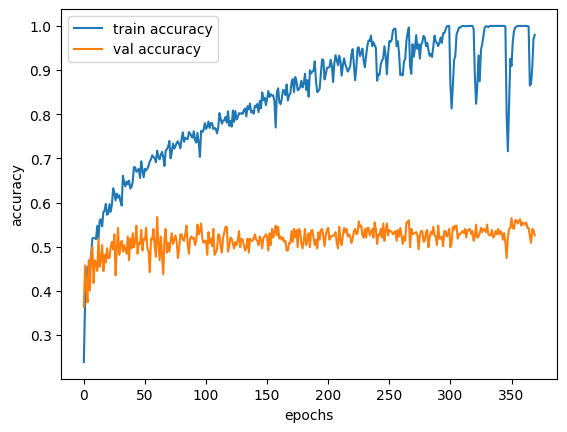

In [ ]:
epochs = list(range(370))
acc = hybrid_model_history.history['accuracy']
val_acc = hybrid_model_history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

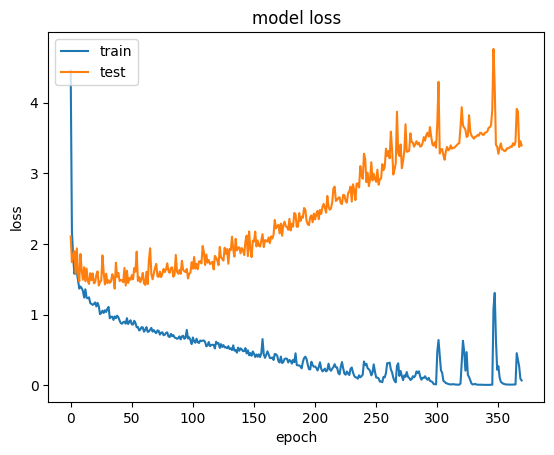

In [ ]:
plt.plot(hybrid_model_history.history['loss'])
plt.plot(hybrid_model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model_name = 'omar.h9'
save_dir = os.path.join(os.getcwd(), '/content/drive/MyDrive/Speech Emotion Recognition/Trained_Models-20230927T075344Z-001/Trained_Models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/MyDrive/Speech Emotion Recognition/Trained_Models-20230927T075344Z-001/Trained_Models/omar.h9 


In [ ]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/Speech Emotion Recognition/Trained_Models-20230927T075344Z-001/Trained_Models/omar.h9")
print("Loaded model from disk")

# evaluate loaded model on test data
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = model.evaluate(x_testcnn, y_test_one_hot, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 16.21%


CNN-SVM Hybrid Model

In [ ]:
import seaborn as sns

Epoch 1/370
128/128 [==============================] - 2s 7ms/step - loss: 2.5566 - accuracy: 0.1756 - val_loss: 1.8796 - val_accuracy: 0.1855
Epoch 2/370
128/128 [==============================] - 1s 6ms/step - loss: 1.9279 - accuracy: 0.2353 - val_loss: 1.7670 - val_accuracy: 0.2695
Epoch 3/370
128/128 [==============================] - 1s 8ms/step - loss: 1.8131 - accuracy: 0.2769 - val_loss: 1.7364 - val_accuracy: 0.3086
Epoch 4/370
128/128 [==============================] - 1s 8ms/step - loss: 1.7652 - accuracy: 0.3072 - val_loss: 1.6712 - val_accuracy: 0.3145
Epoch 5/370
128/128 [==============================] - 1s 8ms/step - loss: 1.7045 - accuracy: 0.3268 - val_loss: 1.6529 - val_accuracy: 0.3477
Epoch 6/370
128/128 [==============================] - 1s 10ms/step - loss: 1.6749 - accuracy: 0.3420 - val_loss: 1.6438 - val_accuracy: 0.3750
Epoch 7/370
128/128 [==============================] - 1s 9ms/step - loss: 1.6403 - accuracy: 0.3684 - val_loss: 1.6228 - val_accuracy: 0.375

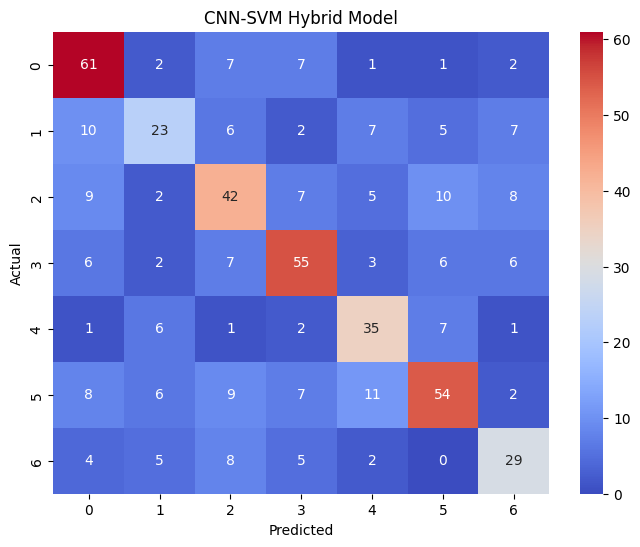

              precision    recall  f1-score   support

           0       0.62      0.75      0.68        81
           1       0.50      0.38      0.43        60
           2       0.53      0.51      0.52        83
           3       0.65      0.65      0.65        85
           4       0.55      0.66      0.60        53
           5       0.65      0.56      0.60        97
           6       0.53      0.55      0.54        53

    accuracy                           0.58       512
   macro avg       0.57      0.58      0.57       512
weighted avg       0.58      0.58      0.58       512



In [ ]:
from keras.optimizers import Adam
import tensorflow as tf
from sklearn.svm import SVC
from tensorflow.keras.layers import BatchNormalization, Dropout

#Build the CNN model
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(x_traincnn.shape[1],x_traincnn.shape[2])))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
num_classes = 7
model.add(Dense(num_classes, activation='softmax'))

#compile and train CNN model
opt = Adam(learning_rate=0.00001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history=model.fit(x_traincnn, y_train_one_hot, batch_size=16, epochs=370, validation_data=(x_testcnn, y_test_one_hot))

#extract features from trained cnn model
features_train = model.predict(x_traincnn)
features_test = model.predict(x_testcnn)

# Create an SVM classifier (you can choose different kernel functions)
clf = svm.SVC(kernel='linear')

# Train the SVM classifier on the training data
clf.fit(features_train, y_train)

# Make predictions on the testing data
y_pred = clf.predict(features_test)

# Evaluate the SVM model
accuracy = accuracy_score(y_test, y_pred)
conf_matx = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Now, you can print or visualize the confusion matrix
print("Confusion Matrix:\n", conf_matx)

#Plotting the confusion mattrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matx, annot=True, cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('CNN-SVM Hybrid Model')
plt.show()

print(classification_report(y_test, y_pred))

In [ ]:
model_name = 'omar.h7'
save_dir = os.path.join(os.getcwd(), '/content/drive/MyDrive/Speech Emotion Recognition/Trained_Models-20230927T075344Z-001/Trained_Models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/MyDrive/Speech Emotion Recognition/Trained_Models-20230927T075344Z-001/Trained_Models/omar.h7 


In [ ]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/Speech Emotion Recognition/Trained_Models-20230927T075344Z-001/Trained_Models/omar.h7")
print("Loaded model from disk")

# evaluate loaded model on test data
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = model.evaluate(x_testcnn, y_test_one_hot, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 58.79%


Ensemble Method

In [ ]:
# Assuming x_traincnn and y_train_one_hot have been defined
print("Number of samples in x_traincnn:", len(x_traincnn))
print("Number of samples in y_train_one_hot:", len(y_train_one_hot))

# Check shapes
print("Shape of x_traincnn:", x_traincnn.shape)
print("Shape of y_train_one_hot:", y_train_one_hot.shape)

Number of samples in x_traincnn: 2044
Number of samples in y_train_one_hot: 2044
Shape of x_traincnn: (2044, 65, 1)
Shape of y_train_one_hot: (2044, 7)


Accuracy: 0.5061124694376528
Confusion Matrix:
 [[42  2  6  2  0  4  1]
 [ 5 17  6  4  2  4  5]
 [ 8  5 21  7  3 16  5]
 [ 7  2 11 34  1  5  7]
 [ 2  5  1  4 41  8  1]
 [ 0  1 17  4  6 36  5]
 [ 6  8 10  3  3  0 16]]


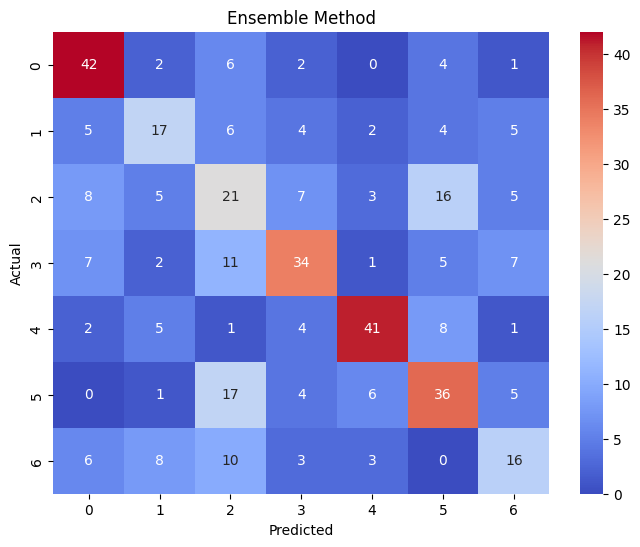

              precision    recall  f1-score   support

           0       0.60      0.74      0.66        57
           1       0.42      0.40      0.41        43
           2       0.29      0.32      0.31        65
           3       0.59      0.51      0.54        67
           4       0.73      0.66      0.69        62
           5       0.49      0.52      0.51        69
           6       0.40      0.35      0.37        46

    accuracy                           0.51       409
   macro avg       0.50      0.50      0.50       409
weighted avg       0.51      0.51      0.51       409



In [ ]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score



# Trim x_traincnn to match the length of y_train_one_hot
x_traincnn = x_traincnn[:len(y_train_one_hot)]

# Trim y_train_one_hot to match the length of x_traincnn
y_train_one_hot = y_train_one_hot[:len(x_traincnn)]

# Ensure consistency
assert len(x_traincnn) == len(y_train_one_hot), "Number of samples in x_traincnn and y_train_one_hot do not match"

#split the data
X_train, X_test, y_train, y_test = train_test_split(x_traincnn, y_train_one_hot, test_size=0.2, random_state=42)

#Define Base Models
base_model1 = RandomForestClassifier(n_estimators=100, random_state=42)
base_model2 = GradientBoostingClassifier(n_estimators=100, random_state=42)
base_model3 = DecisionTreeClassifier(random_state=42)

#Create Stacking Classifier
stacked_model = StackingClassifier(
    estimators=[('rf', base_model1), ('gb', base_model2), ('dt', base_model3)],
    final_estimator=DecisionTreeClassifier()
)

# Reshape X_train to a 2D array
X_train_flat = X_train.reshape(X_train.shape[0], -1)
# Assuming y_train_one_hot has shape (n_samples, n_classes)
y_train_flat = np.argmax(y_train, axis=1)

# Train the Stacking Model
stacked_model.fit(X_train_flat, y_train_flat)



y_test_flat = np.argmax(y_test, axis=1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Make predictions
y_pred = stacked_model.predict(X_test_flat)



#Evaluate Performance
accuracy = accuracy_score(y_test_flat, y_pred)
print(f"Accuracy: {accuracy}")

conf_matrx = confusion_matrix(y_test_flat, y_pred)
classification_rep = classification_report(y_test_flat, y_pred)

# Now, you can print or visualize the confusion matrix
print("Confusion Matrix:\n", conf_matrx)

#Plotting the confusion mattrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrx, annot=True, cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Ensemble Method')
plt.show()

print(classification_report(y_test_flat, y_pred))

Test Set Prediction

Predicting emotions on the test data

In [ ]:
preds = loaded_model.predict(x_testcnn,
                         batch_size=32,
                         verbose=1)

16/16 [==============================] - 0s 3ms/step


In [ ]:
preds

array([[3.5098368e-01, 1.7276602e-02, 2.8319290e-01, ..., 7.1835510e-02,
        6.1148219e-03, 2.3226547e-01],
       [9.4184530e-01, 3.5412994e-03, 4.7700950e-03, ..., 2.6883472e-05,
        6.7863835e-04, 1.8756578e-03],
       [1.3792017e-02, 7.8476250e-01, 6.7001139e-03, ..., 1.6807629e-01,
        8.3014555e-03, 1.3938805e-02],
       ...,
       [7.8098299e-03, 5.2018827e-01, 3.0772069e-01, ..., 9.5408084e-03,
        1.1675251e-03, 4.0012244e-02],
       [7.9566911e-02, 1.3069120e-03, 1.9059825e-01, ..., 4.1672913e-05,
        2.3940574e-01, 4.3685629e-04],
       [3.1294052e-02, 9.3605280e-02, 3.5590969e-02, ..., 2.4061373e-03,
        2.6867692e-03, 7.6829493e-01]], dtype=float32)

In [ ]:
preds1=preds.argmax(axis=1)

In [ ]:
preds1

array([0, 0, 1, 3, 3, 0, 3, 0, 3, 5, 2, 6, 0, 4, 4, 3, 0, 5, 4, 5, 2, 6,
       3, 3, 0, 3, 6, 2, 2, 3, 3, 4, 5, 3, 0, 3, 1, 3, 2, 3, 4, 6, 1, 0,
       5, 0, 1, 1, 1, 5, 1, 3, 3, 4, 4, 5, 2, 0, 5, 4, 4, 0, 4, 0, 0, 3,
       5, 0, 0, 3, 3, 2, 6, 2, 4, 5, 5, 6, 0, 1, 5, 3, 0, 2, 3, 3, 6, 0,
       6, 0, 3, 0, 4, 2, 2, 3, 6, 5, 4, 6, 0, 4, 5, 4, 3, 5, 2, 3, 6, 3,
       2, 0, 0, 3, 4, 5, 3, 5, 5, 0, 5, 3, 6, 3, 0, 3, 1, 0, 5, 0, 1, 0,
       4, 3, 4, 0, 3, 0, 3, 4, 0, 0, 1, 2, 0, 0, 1, 3, 4, 2, 5, 0, 4, 0,
       5, 4, 1, 0, 6, 1, 0, 5, 5, 5, 0, 0, 4, 4, 1, 6, 6, 5, 6, 4, 6, 0,
       6, 0, 6, 5, 1, 0, 4, 6, 0, 2, 2, 2, 1, 0, 3, 0, 4, 1, 4, 1, 0, 6,
       2, 0, 0, 2, 4, 4, 6, 3, 4, 6, 0, 4, 3, 3, 2, 0, 4, 4, 4, 6, 3, 4,
       5, 3, 0, 3, 4, 4, 1, 5, 3, 1, 5, 4, 4, 4, 0, 3, 4, 5, 4, 6, 6, 4,
       5, 2, 4, 5, 2, 2, 1, 0, 1, 4, 0, 3, 0, 1, 1, 1, 3, 4, 3, 3, 4, 4,
       0, 6, 5, 6, 2, 2, 5, 4, 6, 5, 4, 3, 3, 3, 0, 0, 2, 0, 5, 3, 6, 5,
       3, 4, 5, 1, 5, 3, 4, 6, 4, 0, 5, 5, 4, 0, 5,

In [ ]:
abc = preds1.astype(int).flatten()

In [ ]:
predictions = (lb.inverse_transform((abc)))

In [ ]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,0
1,0
2,1
3,3
4,3
5,0
6,3
7,0
8,3
9,5


In [ ]:
actual=y_test_one_hot.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [ ]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,2
1,0
2,1
3,2
4,3
5,6
6,6
7,5
8,3
9,5


In [ ]:
finaldf = actualdf.join(preddf)

Actual v/s Predicted emotions

In [ ]:
finaldf[130:140]

,actualvalues,predictedvalues
130,1,1
131,5,0
132,1,4
133,3,3
134,4,4
135,0,0
136,3,3
137,0,0
138,1,3
139,6,4


In [ ]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
0,81
1,60
2,83
3,85
4,53
5,97
6,53


In [ ]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
0,101
1,41
2,51
3,105
4,76
5,79
6,59


In [ ]:
finaldf.to_csv('Predictions.csv', index=False)

Live Demonstration

In [ ]:
demo_audio_path = '/content/drive/MyDrive/Speech Emotion Recognition/demo_audio5.wav'
ipd.Audio('/content/drive/MyDrive/Speech Emotion Recognition/demo_audio5.wav')
y, sr = librosa.load(demo_audio_path)

# Extract chroma feature
chroma = librosa.feature.chroma_stft(y=y, sr=sr)


In [ ]:
sampling_rate = 44100

In [ ]:
import sys
print(sys.executable)


/usr/bin/python3


In [ ]:
#!pip uninstall resampy
!pip install resampy


In [ ]:
import resampy
# Extract audio features using get_audio_features function (assuming it's defined)
demo_mfcc, demo_pitch, demo_mag, demo_chrom = get_audio_features(demo_audio_path, sampling_rate)

# Create pandas Series for each feature
mfcc_series = pd.Series(demo_mfcc)
pitch_series = pd.Series(demo_pitch)
mag_series = pd.Series(demo_mag)
chroma_series = pd.Series(demo_chrom)

# Concatenate the Series into a single DataFrame
demo_audio_features = pd.concat([mfcc_series, pitch_series, mag_series, chroma_series], ignore_index=True)

# Optionally, you can give meaningful column names to the DataFrame
demo_audio_features.columns = ["MFCC", "Pitch", "Magnitude", "Chroma"]

# Display the resulting DataFrame
print(demo_audio_features)

ModuleNotFoundError: ignored

In [ ]:
demo_mfcc, demo_pitch, demo_mag, demo_chrom = get_audio_features(demo_audio_path,sampling_rate)

mfcc = pd.Series(demo_mfcc)
pit = pd.Series(demo_pitch)
mag = pd.Series(demo_mag)
C = pd.Series(demo_chrom)
demo_audio_features = pd.concat([mfcc,pit,mag,C],ignore_index=True)

In [ ]:
demo_audio_features= np.expand_dims(demo_audio_features, axis=0)
demo_audio_features= np.expand_dims(demo_audio_features, axis=2)

In [ ]:
demo_audio_features.shape

In [ ]:
livepreds = loaded_model.predict(demo_audio_features,
                         batch_size=32,
                         verbose=1)

In [ ]:
livepreds

In [ ]:
emotions=["anger","disgust","fear","happy","neutral", "sad", "surprise"]
index = livepreds.argmax(axis=1).item()
index

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame()

In [ ]:
df.head(3)

In [ ]:
emotions[index]